In [1]:
import jax.numpy as jnp
import jax
import jax.random as jr

from optimizers.gd import SGDState, sgd_step


from optimizers.mrcg import MRCGState, mrcg_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

In [2]:
# initial_params = jnp.array([1.0, 2.0, 3.0])

# def model(params, x):
#     return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

# def loss(y_pred, y_true):
#     return jnp.mean((y_pred - y_true) ** 2)
# x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# y_true = jnp.array([[1.0], [2.0]])

# def loss_at_params(params, key=None):
#     y_pred = model(params, x)
#     return loss(y_pred, y_true)
# loss_at_params(initial_params)


In [3]:
import jax.numpy as jnp
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error




# Load and preprocess the dataset
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)  # Make it a column vector

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)
TOTAL_SAMPLES = X.shape[0]

# We find the optimum solution of the regression problem.
model = LinearRegression()
model.fit(X, y)

# Get predictions and compute train MSE
y_pred = model.predict(X)
optimal_loss = mean_squared_error(y, y_pred)
print(optimal_loss)

0.3937673148001949


In [4]:

# Convert to JAX arrays
x = jnp.array(X)
y_true = jnp.array(y)

# Initial parameters for each feature
initial_params = jnp.ones(x.shape[1])  # One param per feature

def batched_loss_at_params(batch_size):
    # Model: simple linear regression
    def model(params, x):
        return jnp.dot(x, params)

    # Loss: mean squared error

    # Loss function with parameters
    def loss_at_params(params, key):
        batch = jr.choice(key, jnp.arange(x.shape[0]), shape=(batch_size,), replace=False)
        x_batch = x[batch]
        y_batch = y_true[batch]
        def loss(y_pred, y_true):
            return jnp.mean((y_pred - y_true.squeeze()) ** 2)

        y_pred = model(params, x_batch)
        return loss(y_pred, y_batch)
    return loss_at_params


In [5]:

l = batched_loss_at_params(5000)
l(initial_params, jr.key(6))

Array(8.463736, dtype=float32)

In [6]:

def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    key = jr.PRNGKey(0)
    for i in range(max_iters):
        key, subkey = jr.split(key)
        loss = state.loss_at_params(state.params, subkey)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

In [16]:
from matplotlib.pyplot import plot
key = jr.key(0)

loss_functions = [(f"{100*r:.1f}%", batched_loss_at_params(int(r*TOTAL_SAMPLES))) for r in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5] ]


def plot_comparison(methods, iterations = 100):
    results = {}
    for name, initial_state, step_fn in methods:
        losses = iterate_alg(iterations, initial_state, step_fn, verbose=False)
        results[name] = losses

    for name, losses in results.items():
        plt.plot(losses, label=name)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over iterations')
    plt.yscale('log')
    plt.legend()
    # Show horizontal line at　0.4
    plt.axhline(y=optimal_loss, color='r', linestyle='--', label='Target Loss (0.4)')


In [ ]:

methods = [(f"mcgs {name}", MRCGState(initial_params, loss_ap, key), mrcg_step) for name, loss_ap in loss_functions]
plot_comparison(methods)

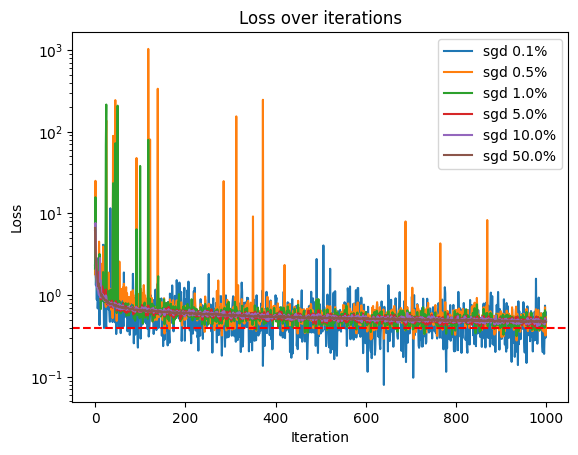

In [17]:
def step_size(n):
    return 0.1 / (n+1)**.5
methods = [(f"sgd {name}", SGDState(initial_params, loss_ap, step_size, key), sgd_step) for name, loss_ap in loss_functions]
plot_comparison(methods, iterations=1000)